In [1]:
#Importing Important python module.
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
import string
from sklearn.model_selection import train_test_split  
from random import shuffle
from sklearn import svm
from sklearn.externals import joblib
from sklearn.pipeline import Pipeline
import pickle
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score,roc_curve,auc,f1_score,precision_score,recall_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier 
from sklearn.linear_model import SGDClassifier
import matplotlib.pyplot as plt
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [2]:
#Loading Dataset and spliting it in Train and Test set.
train=pd.read_csv("train123.csv",header=None,encoding='ISO-8859-1')
test=pd.read_csv("uniondata.csv")
train.columns=["label","1","2","3","4","tweet"]
d=train[["tweet","label"]]
x=train["tweet"].tolist()
y=train["label"].tolist()
X_train, X_test, y_train, y_test = train_test_split(x,y,test_size=0.20, random_state=42)
x_test=test["tweets"].tolist()
print(train.head(10))
test.head(10)

   label           1                             2         3                4  \
0      0  1467810369  Mon Apr 06 22:19:45 PDT 2009  NO_QUERY  _TheSpecialOne_   
1      0  1467810672  Mon Apr 06 22:19:49 PDT 2009  NO_QUERY    scotthamilton   
2      0  1467810917  Mon Apr 06 22:19:53 PDT 2009  NO_QUERY         mattycus   
3      0  1467811184  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY          ElleCTF   
4      0  1467811193  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY           Karoli   
5      0  1467811372  Mon Apr 06 22:20:00 PDT 2009  NO_QUERY         joy_wolf   
6      0  1467811592  Mon Apr 06 22:20:03 PDT 2009  NO_QUERY          mybirch   
7      0  1467811594  Mon Apr 06 22:20:03 PDT 2009  NO_QUERY             coZZ   
8      0  1467811795  Mon Apr 06 22:20:05 PDT 2009  NO_QUERY  2Hood4Hollywood   
9      0  1467812025  Mon Apr 06 22:20:09 PDT 2009  NO_QUERY          mimismo   

                                               tweet  
0  @switchfoot http://twitpic.com/2y1zl - Awww, t... 

,tweets
0,Talk on Union Budget 2019!! pic.twitter.com/8D...
1,Here is a quick highlight on Union Budget 2019...
2,Union Budget 2019: \r\n\r\nAuto Industry Disap...
3,"Mr. Dhiraj Jain, Director, Mahagun India, shar..."
4,A 19 Years Old Teenager @tarak9999 breaks All ...
5,5 trillion for who ?? Ambani ?? Union Budget 2...
6,Union Budget 2019: Railways focus to be on saf...
7,.@nsitharaman to present Union Budget of Modi ...
8,The process of legislative reforms on Labour i...
9,#Moneypitara: Highlights of Budget 2019-20: #B...


In [21]:
f1score=[]
precission=[]
recall=[]

# Lexicon Based Aproach

In [22]:
#importing test dataset
data = pd.read_csv("uniondata.csv")
#instanciating the SentimentIntensityAnalyzer object from vader sentiment analyzer
sid = SentimentIntensityAnalyzer()
listy = []
pos,neg=0,0
#calculating the polarity score of all the tweets
for index, row in data.iterrows():
    ss = sid.polarity_scores(row["tweets"])
    if ss['compound'] >= 0.0 : 
        pos+=1 
        score=1
    else: 
        neg+=1
        score=0
    g=[ss,score]
    listy.append(g)
sentiment_scores={"Positive":pos,"Negetive":neg}
se = pd.DataFrame(listy,columns=["polarity","lexicon label"])
data=pd.concat([data, se], axis=1)
print("Positive: ",sentiment_scores["Positive"])
print("Negetive: ",sentiment_scores["Negetive"])

Positive:  608
Negetive:  101


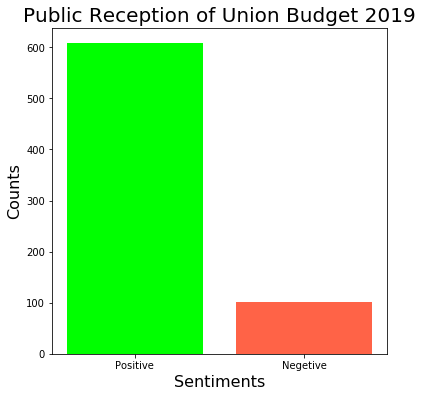

<Figure size 432x288 with 0 Axes>

In [10]:
#countplot for positive and negetive sentiments
fig = plt.figure(figsize=(6,6))
plt.bar(range(len(sentiment_scores)),list(sentiment_scores.values()),tick_label=list(sentiment_scores.keys()),color=['lime', 'tomato', 'cyan'])
plt.xlabel('Sentiments',fontsize=16)
plt.ylabel('Counts',fontsize=16)
plt.title('Public Reception of Union Budget 2019', fontsize=20)
plt.show()
plt.savefig("C:\\Users\kools\\Desktop\\Assignment\\graph9.png",bbox_inches="tight",pad_inches=2)

# Machine Learning Approach

In [9]:
#Pre-processing and Cleaning of Tweets. Like removing URL,@Username,Hagtag,Repating etc..
def preprocessTweets(tweet):
    #Convert www.* or https?://* to URL
    tweet = re.sub('((www\.[^\s]+)|(https?://[^\s]+))','URL',tweet)
    #Convert @username to __HANDLE
    tweet = re.sub('@[^\s]+','__HANDLE',tweet)  
    #Replace #word with word
    tweet = re.sub(r'#([^\s]+)', r'\1', tweet)
    #trim
    tweet = tweet.strip('\'"')
    # Repeating words like akashhhhhhhhhhh
    rpt_regex = re.compile(r"(.)\1{1,}", re.IGNORECASE)
    tweet = rpt_regex.sub(r"\1\1", tweet)
    #Emoticons
    emoticons = \
    [
     ('__positive__',[ ':-)', ':)', '(:', '(-:', \
                       ':-D', ':D', 'X-D', 'XD', 'xD', \
                       '<3', ':\*', ';-)', ';)', ';-D', ';D', '(;', '(-;', ] ),\
     ('__negative__', [':-(', ':(', '(:', '(-:', ':,(',\
                       ':\'(', ':"(', ':((', ] ),\
    ]
    def replace_parenth(arr):
       return [text.replace(')', '[)}\]]').replace('(', '[({\[]') for text in arr]
    
    def regex_join(arr):
        return '(' + '|'.join( arr ) + ')'

    emoticons_regex = [ (repl, re.compile(regex_join(replace_parenth(regx))) ) \
            for (repl, regx) in emoticons ]
    
    for (repl, regx) in emoticons_regex :
        tweet = re.sub(regx, ' '+repl+' ', tweet)
     #Convert to lower case
    tweet = tweet.lower()
    return tweet
#Stemming of Tweets
def stem(tweet):
        stemmer = nltk.stem.PorterStemmer()
        tweet_stem = ''
        words = [word if(word[0:2]=='__') else word.lower() \
                    for word in tweet.split() \
                    if len(word) >= 3]
        words = [stemmer.stem(w) for w in words] 
        tweet_stem = ' '.join(words)
        return tweet_stem

In [10]:
#Processing tweets.
def processTweets(X):
        X = [stem(preprocessTweets(tweet)) for tweet in X]
        return X

In [ ]:
#Getting cleaned X_train and X_test Data.
X_train = processTweets(X_train)

In [11]:
#Getting cleaned X_test and x_test Data.
X_test = processTweets(X_test)
x_test = processTweets(x_test)

In [ ]:
#Vectorization of data to train it.
vec = TfidfVectorizer(min_df=5, max_df=0.95, sublinear_tf = True,use_idf = True,ngram_range=(1, 2))

In [ ]:
#Support Vector Machine classifier Model.
def classifier(X_train,y_train):
        svm_clf =svm.LinearSVC()
        vec_clf = Pipeline([('vectorizer', vec), ('pac', svm_clf)])
        vec_clf.fit(X_train,y_train)
        joblib.dump(vec_clf, 'svmClassifier.pkl', compress=3)
        return vec_clf
vec_clf1 = classifier(X_train,y_train)

In [ ]:
#Stochastic Gradient Descent classifier Model.
def classifiersgd(X_train,y_train):
        svm_clf =SGDClassifier()
        vec_clf = Pipeline([('vectorizer', vec), ('pac', svm_clf)])
        vec_clf.fit(X_train,y_train)
        joblib.dump(vec_clf, 'sgdClassifier.pkl', compress=3)
        return vec_clf
vec_clf2 = classifiersgd(X_train,y_train)

In [ ]:
#Random Forest Classsifier Model
def classifierRFC(X_train,y_train):
        svm_clf =RandomForestClassifier(n_estimators=100,max_depth=5)
        vec_clf = Pipeline([('vectorizer', vec), ('pac', svm_clf)])
        vec_clf.fit(X_train,y_train)
        joblib.dump(vec_clf, 'RFCClassifier.pkl', compress=3)
        return vec_clf
vec_clf3 = classifierRFC(X_train,y_train)

In [ ]:
#Naive-Bayes Multinomial Model
def classifierNB(X_train,y_train):
        svm_clf =MultinomialNB()
        vec_clf = Pipeline([('vectorizer', vec), ('pac', svm_clf)])
        vec_clf.fit(X_train,y_train)
        joblib.dump(vec_clf, 'MNBClassifier.pkl', compress=3)
        return vec_clf
vec_clf4 = classifierNB(X_train,y_train)

#### Trained Classifier for SVCclassifier and Their Produced Result

In [12]:
#Loading SVC Classifier Model
classifier_f = open("svmClassifier.pkl", "rb")
classifierSVC = joblib.load(classifier_f)
classifier_f.close()

In [23]:
#Predict the X_test on svmclassifier
y_predSVC = classifierSVC.predict(X_test)
Y_predSVC = classifierSVC.predict(x_test)
posSVC=[w for w in Y_predSVC if w==4]
negSVC=[w for w in Y_predSVC if w==0]


In [32]:
#ACCURACY SCORE,AUC,AND CLASSIFICATION REPORT
print("The Accuracy Score is :",accuracy_score(y_test,y_predSVC))
fpr,tpr,threshold = roc_curve(y_test,y_predSVC,pos_label=4)
print("The False Positive Rate is {} and The True Positive Rate is {}".format(fpr,tpr))
print("The Accuracy of False Positive Rate and True Positive Rate is ",auc(fpr,tpr))
print("The classification Report is : ",end="\n")
print(classification_report(y_test,y_predSVC))

The Accuracy Score is : 0.804896875
The False Positive Rate is [0.         0.19944951 1.        ] and The True Positive Rate is [0.         0.80921585 1.        ]
The Accuracy of False Positive Rate and True Positive Rate is  0.8048831728932834
The classification Report is : 
              precision    recall  f1-score   support

           0       0.81      0.80      0.80    159494
           4       0.80      0.81      0.81    160506

   micro avg       0.80      0.80      0.80    320000
   macro avg       0.80      0.80      0.80    320000
weighted avg       0.80      0.80      0.80    320000



In [33]:
f1score.append(f1_score(y_test,y_predSVC,pos_label=4))
precission.append(precision_score(y_test,y_predSVC,pos_label=4))
recall.append(recall_score(y_test,y_predSVC,pos_label=4))

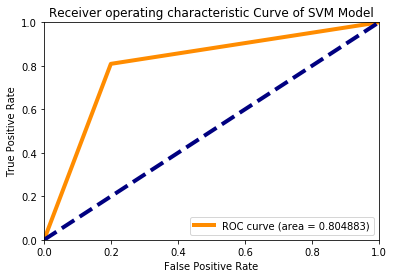

<Figure size 432x288 with 0 Axes>

In [34]:
#Ploting ROC-Curve.
plt.figure()
lw = 4
plt.plot(fpr, tpr, color='darkorange',lw=lw, label='ROC curve (area = %f)' % auc(fpr,tpr))
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic Curve of SVM Model')
plt.legend(loc="lower right")
plt.show()
plt.savefig("C:\\Users\kools\\Desktop\\Assignment\\sachin\\graph1.png",bbox_inches="tight",pad_inches=2)

#### Trained Classifier for SGDclassifier and Their Produced Result

In [14]:
#Loading SGD Classifier.
classifier_f = open("sgdClassifier.pkl", "rb")
classifierSGD = joblib.load(classifier_f)
classifier_f.close()

In [24]:
#Predict The X_test on SGD model.
y_predSGD = classifierSGD.predict(X_test)
Y_predSGD = classifierSGD.predict(x_test)
posSGD=[w for w in Y_predSGD if w==4]
negSGD=[w for w in Y_predSGD if w==0]


In [37]:
#ACCURACY SCORE,AUC,AND CLASSIFICATION REPORT
print("The Accuracy Score is :",accuracy_score(y_test,y_predSGD))
fpr,tpr,threshold = roc_curve(y_test,y_predSGD,pos_label=4)
print("The False Positive Rate is {} and The True Positive Rate is {}".format(fpr,tpr))
print("The Accuracy of False Positive Rate and True Positive Rate is ",auc(fpr,tpr))
print("The classification Report is : ",end="\n")
print(classification_report(y_test,y_predSGD))

The Accuracy Score is : 0.781009375
The False Positive Rate is [0.         0.23046008 1.        ] and The True Positive Rate is [0.         0.79240651 1.        ]
The Accuracy of False Positive Rate and True Positive Rate is  0.780973217197603
The classification Report is : 
              precision    recall  f1-score   support

           0       0.79      0.77      0.78    159494
           4       0.78      0.79      0.78    160506

   micro avg       0.78      0.78      0.78    320000
   macro avg       0.78      0.78      0.78    320000
weighted avg       0.78      0.78      0.78    320000



array([[122737,  36757],
       [ 33320, 127186]], dtype=int64)

In [38]:
f1score.append(f1_score(y_test,y_predSVC,pos_label=4))
precission.append(precision_score(y_test,y_predSGD,pos_label=4))
recall.append(recall_score(y_test,y_predSGD,pos_label=4))

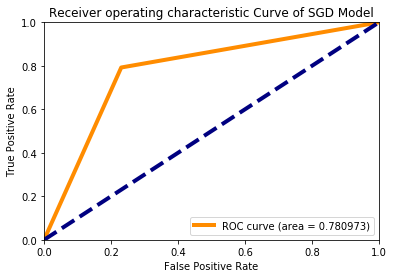

<Figure size 432x288 with 0 Axes>

In [39]:
#ROC-Curve of SGD Classifier.
plt.figure()
lw = 4
plt.plot(fpr, tpr, color='darkorange',lw=lw, label='ROC curve (area = %f)' % auc(fpr,tpr))
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic Curve of SGD Model')
plt.legend(loc="lower right")
plt.show()
plt.savefig("C:\\Users\kools\\Desktop\\Assignment\\graph2.png",bbox_inches="tight",pad_inches=2)

#### Trained Classifier for RFCclassifier and Their Produced Result

In [16]:
#Loading RFC Classifier.
classifier_f = open("RFCClassifier.pkl", "rb")
classifierRFC = joblib.load(classifier_f)
classifier_f.close()

In [28]:
#Predict X_test on RFC Model.
y_predRFC = classifierRFC.predict(X_test)
Y_predRFC = classifierRFC.predict(x_test)
posRFC=[w for w in Y_predRFC if w==4]
negRFC=[w for w in Y_predRFC if w==0]

In [41]:
#ACCURACY SCORE,AUC,AND CLASSIFICATION REPORT
print("The Accuracy Score is :",accuracy_score(y_test,y_predRFC))
fpr,tpr,threshold = roc_curve(y_test,y_predRFC,pos_label=4)
print("The False Positive Rate is {} and The True Positive Rate is {}".format(fpr,tpr))
print("The Accuracy of False Positive Rate and True Positive Rate is ",auc(fpr,tpr))
print("The classification Report is : ",end="\n")
print(classification_report(y_test,y_predRFC))

The Accuracy Score is : 0.692759375
The False Positive Rate is [0.         0.26506953 1.        ] and The True Positive Rate is [0.         0.65085417 1.        ]
The Accuracy of False Positive Rate and True Positive Rate is  0.6928923206397737
The classification Report is : 
              precision    recall  f1-score   support

           0       0.68      0.73      0.70    159494
           4       0.71      0.65      0.68    160506

   micro avg       0.69      0.69      0.69    320000
   macro avg       0.69      0.69      0.69    320000
weighted avg       0.69      0.69      0.69    320000



In [42]:
f1score.append(f1_score(y_test,y_predRFC,pos_label=4))
precission.append(precision_score(y_test,y_predRFC,pos_label=4))
recall.append(recall_score(y_test,y_predRFC,pos_label=4))

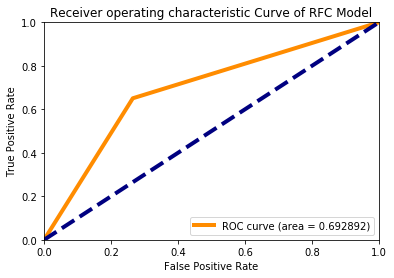

<Figure size 432x288 with 0 Axes>

In [43]:
#ROC_Curve of RFC Classifer.
plt.figure()
lw = 4
plt.plot(fpr, tpr, color='darkorange',lw=lw, label='ROC curve (area = %f)' % auc(fpr,tpr))
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic Curve of RFC Model')
plt.legend(loc="lower right")
plt.show()
plt.savefig("C:\\Users\kools\\Desktop\\Assignment\\graph3.png",bbox_inches="tight",pad_inches=2)

#### Trained Classifier for Naive-Byes Multinomial Classifier and Their Produced Result

In [18]:
#Loading Naive-Bayes Multinomial Calssifier.
classifier_f = open("MNBClassifier.pkl", "rb")
classifierMNB = joblib.load(classifier_f)
classifier_f.close()

In [25]:
#Pridict X_test on Naive-Byes Model.
y_predMNB = classifierMNB.predict(X_test)
Y_predMNB = classifierMNB.predict(x_test)
posMNB=[w for w in Y_predMNB if w==4]
negMNB=[w for w in Y_predMNB if w==0]

In [45]:
#ACCURACY SCORE,AUC,AND CLASSIFICATION REPORT
print("The Accuracy Score is :",accuracy_score(y_test,y_predMNB))
fpr,tpr,threshold = roc_curve(y_test,y_predMNB,pos_label=4)
print("The False Positive Rate is {} and The True Positive Rate is {}".format(fpr,tpr))
print("The Accuracy of False Positive Rate and True Positive Rate is ",auc(fpr,tpr))
print("The classification Report is : ",end="\n")
print(classification_report(y_test,y_predMNB))

The Accuracy Score is : 0.799496875
The False Positive Rate is [0.         0.19571269 1.        ] and The True Positive Rate is [0.         0.79473665 1.        ]
The Accuracy of False Positive Rate and True Positive Rate is  0.7995119769862711
The classification Report is : 
              precision    recall  f1-score   support

           0       0.80      0.80      0.80    159494
           4       0.80      0.79      0.80    160506

   micro avg       0.80      0.80      0.80    320000
   macro avg       0.80      0.80      0.80    320000
weighted avg       0.80      0.80      0.80    320000



In [46]:
f1score.append(f1_score(y_test,y_predMNB,pos_label=4))
precission.append(precision_score(y_test,y_predMNB,pos_label=4))
recall.append(recall_score(y_test,y_predMNB,pos_label=4))

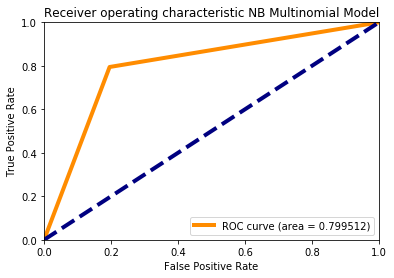

<Figure size 432x288 with 0 Axes>

In [47]:
#ROC-Curve of NB Multinomial Model.
plt.figure()
lw = 4
plt.plot(fpr, tpr, color='darkorange',lw=lw, label='ROC curve (area = %f)' % auc(fpr,tpr))
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic NB Multinomial Model')
plt.legend(loc="lower right")
plt.show()
plt.savefig("C:\\Users\kools\\Desktop\\Assignment\\graph4.png",bbox_inches="tight",pad_inches=2)

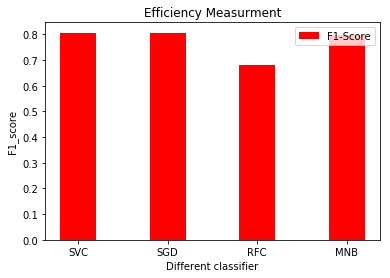

In [48]:
#Bar plot for F1-Score
s=["SVC","SGD","RFC","MNB"]
xpos=np.arange(len(s))
plt.xticks(xpos,s)
plt.xlabel("Different classifier")
plt.ylabel("F1_score")
plt.title("Efficiency Measurment")
plt.bar(xpos-0,f1score,color='red',width=0.4,label='F1-Score')
plt.legend(loc="best")
plt.savefig("C:\\Users\kools\\Desktop\\Assignment\\graph5.png",bbox_inches="tight",pad_inches=2)

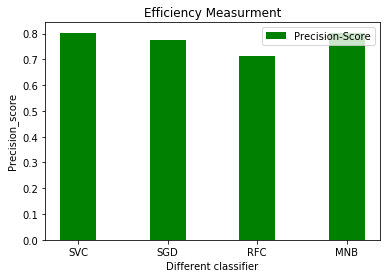

In [49]:
#Bar plot for Precision-Score
s=["SVC","SGD","RFC","MNB"]
xpos=np.arange(len(s))
plt.xticks(xpos,s)
plt.xlabel("Different classifier")
plt.ylabel("Precision_score")
plt.title("Efficiency Measurment")
plt.bar(xpos+0,precission,color='green',width=0.4,label='Precision-Score')
plt.legend(loc="best")
plt.savefig("C:\\Users\kools\\Desktop\\Assignment\\graph6.png",bbox_inches="tight",pad_inches=2)

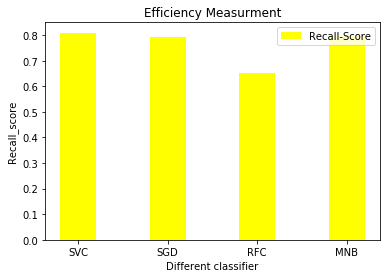

In [50]:
#Bar plot for Recall-Score
s=["SVC","SGD","RFC","MNB"]
xpos=np.arange(len(s))
plt.xticks(xpos,s)
plt.xlabel("Different classifier")
plt.ylabel("Recall_score")
plt.title("Efficiency Measurment")
plt.bar(xpos+0,recall,color='yellow',width=0.4,label='Recall-Score')
plt.legend(loc="best")
plt.savefig("C:\\Users\kools\\Desktop\\Assignment\\graph7.png",bbox_inches="tight",pad_inches=2)

In [52]:
finalPOS=[]
finalNEG=[]
finalPOS.append(len(posSVC))
finalPOS.append(len(posSGD))
finalPOS.append(len(posRFC))
finalPOS.append(len(posMNB))
finalNEG.append(len(negSVC))
finalNEG.append(len(negSGD))
finalNEG.append(len(negRFC))
finalNEG.append(len(negMNB))
finalPOS.append(sentiment_scores["Positive"])
finalNEG.append(sentiment_scores["Negetive"])

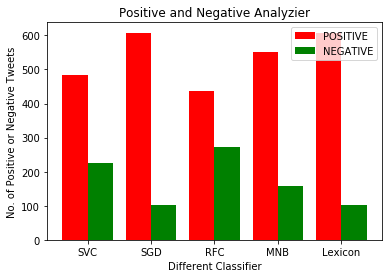

In [54]:
#Plot for no. of positive and Negative Tweets.
s=["SVC","SGD","RFC","MNB","Lexicon"]
xpos=np.arange(len(s))
plt.xticks(xpos,s)
plt.xlabel("Different Classifier")
plt.ylabel("No. of Positive or Negative Tweets")
plt.title("Positive and Negative Analyzier")
plt.bar(xpos-0.2,finalPOS,color='red',width=0.4,label='POSITIVE')
plt.bar(xpos+0.2,finalNEG,color='green',width=0.4,label='NEGATIVE')
plt.legend(loc="best")
plt.savefig("C:\\Users\kools\\Desktop\\Assignment\\graph8.png",bbox_inches="tight",pad_inches=2)